# Multigrid method, applications to PDEs
### Final project, _Advanced Numerical Analysis_ (27/09/2022) - MSc in DSSC

In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import scipy.sparse as sp
import sympy as sym

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

font = {"family": "sans-serif", "weight": "bold", "size": 13}

from abc import ABC
import time

## General goal
Solving the linear system:
$$\large \mathbf{Au} = \mathbf{b}$$
## Iterative methods
$$\large \mathbf{Mu}^{n+1} = \mathbf{Nu}^n + \mathbf{f}$$

__Example__: Jacobi method:
$$\large \mathbf{u}^{n+1} = \mathbf{u}^n + \mathbf{D}^{-1} \mathbf{r}^n$$
with $\mathbf{r}^n = f - \mathbf{Au}^n$. Stop when some criteria is satisfied (e.g. $\lVert r^n\rVert < \epsilon$).

In [2]:
def jacobi(A, b, x):
    r = b - A.dot(x)
    return x + sp.diags(1 / A.diagonal()).dot(r)


def gauss_seidel(A, b, x):
    x_old = np.array(x)
    for i in range(A.shape[0]):
        x[i] = b[i] - A[i, :i].dot(x[:i]) - A[i, (i + 1) :].dot(x_old[(i + 1) :])
    return x / A.diagonal()


def conjugate_gradient(A, b, x):
    return sp.linalg.cg(A, b, x0=x, maxiter=1)[0]

### Problems
- Convergence is slow asymptotically
- Hard to parallelize across different steps
- Conditioning of $\large A$

## Multigrid method
__Idea__: Solve the problem on a _coarser_ (i.e. cheaper) space, with some corrections.

### Restriction and prolongation
To move back and forth:
- _Restriction_ operator $\large I_h^{2h}: V^h \to V^{2h}$
- _Prolongation_ operator $\large I_{2h}^h: V^{2h} \to V^h$

__Example__:
- Restriction: injection: $\large v_j^{2h} = v^h_{2j}$;
- Prolongation: 2-points interpolation: $\large v_{2j+1}^{h} = (v_j^{2h} + v_{j+1}^{2h}) / 2$.

### Basic idea
Starting from the grid $\large \Omega^h$ for some discretization parameter $h$, we want to solve
$$\large A^h u^h = f^h$$

1. Perform a few steps of an iterative method to find an approximate solution $\large v^h$;
2. Compute the residual $\large r^h := f^h - A^h v^h$;
3. Jump (with $\large I_h^{2h}$) to a coarser space $\large \Omega^{2h}$ (thus compute $\large A^{2h}, f^{2h} := I_h^{2h}(r^h)$);
4. Solve $\large \large A^{2h} v^{2h} = f^{2h}$;
5. Correct $\large v^h$: $\large v^h = v^h + I^{2h}_h(v^2h)$;
6. Perform a few steps of an iterative method using $\large v^h$ as the initial guess.

Last step is valid since $\large A^h e^h = A^h(u - u^h) = f - A^h u^h = r^h$.

In [3]:
def fem_prolongation(x):
    l = len(x)
    data = np.tile((0.5, 1, 0.5), l)
    rows = (
        np.array([0, 1, 2])[None] + np.array([2])[None] * np.arange(l)[:, None]
    ).flatten()
    cols = (
        np.array([0, 0, 0])[None] + np.array([1])[None] * np.arange(l)[:, None]
    ).flatten()
    return sp.coo_matrix((data, (rows, cols))).tocsr()


def weighted_restriction(x):
    l = len(x) // 2
    data = np.tile((0.25, 0.5, 0.25), l)
    cols = (
        np.array([0, 1, 2])[None] + np.array([2])[None] * np.arange(l)[:, None]
    ).flatten()
    rows = (
        np.array([0, 0, 0])[None] + np.array([1])[None] * np.arange(l)[:, None]
    ).flatten()
    return sp.coo_matrix((data, (rows, cols))).tocsr()

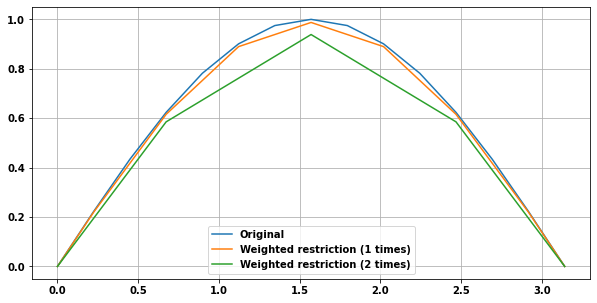

In [4]:
def restrict(x, times):
    for _ in range(times):
        x = weighted_restriction(x).dot(x)
    return x

def wrap(x, start=0, end=0):
    return np.concatenate(([start], x, [end]))

omega = np.linspace(0, np.pi, 15)
data = np.sin(omega)

plt.rc("font", **font)
plt.figure(figsize=(10, 5))
plt.plot(omega, data, "-", label="Original")
plt.plot(wrap(restrict(omega, 1), end=omega[-1]), wrap(restrict(data, 1)), 
         label="Weighted restriction (1 times)")
plt.plot(wrap(restrict(omega, 2), end=omega[-1]), wrap(restrict(data, 2)), 
         label="Weighted restriction (2 times)")

plt.legend()
plt.grid()

plt.show()

In [5]:
def multigrid(
    Ah, fh, smoother_info, hm_threshold, restriction, prolongation, vh=None, hm=0, gamma=1, solver=np.linalg.solve
):
    """
    v1: pre-smoothing
    v2: post-smoothing
    smoother: (A, f, vh) -> vh'
    """
    smoother, v1, v2 = smoother_info

    if vh is None:
        vh = np.zeros_like(fh)
    for _ in range(v1):
        vh = smoother(Ah, fh, vh)
        
    if hm == hm_threshold:
        vh = solver(Ah, fh)
    else:
        rh = fh - Ah.dot(vh)
        rmatrix = restriction(rh)
        f2h = rmatrix.dot(rh)

        pmatrix = prolongation(f2h)
        A2h = rmatrix.dot((pmatrix.transpose().dot(Ah.T)).transpose())
        
        v2h = None
        for _ in range(gamma):
            v2h = multigrid(
                A2h,
                f2h,
                smoother_info,
                hm_threshold,
                restriction,
                prolongation,
                vh=v2h,
                hm=hm + 1,
                gamma=gamma,
                solver=solver
            )
        vh += pmatrix.dot(v2h)

    for _ in range(v2):
        vh = smoother(Ah, fh, vh)

    return vh

## 1D Poisson problem
$$\large
\begin{cases}
-\frac{d^2u}{dx^2} = 0\\
u(0) = u(1) = 0
\end{cases}
$$

Discretization with Finite Differences:
$$\large - \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2} = 0$$

In matrix form (no boundary condition):
$$\mathbf{A} := -\frac{1}{h^2} \begin{bmatrix}
1 & -2 & 1 & 0 & 0 & \dots & 0\\
0 & 1 & -2 & 1 & 0 & \dots & 0\\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots\\
0 & \dots & \dots & \dots & 1 & -2 & 1
\end{bmatrix}$$

In [6]:
def homo_diffusion_problem(N, rhs_f, a=0, b=1):
    omega = np.linspace(a, b, N)
    h = omega[1] - omega[0]
    inverse_squared_h = 1 / (h**2)

    rhs = rhs_f(omega)

    A = (
        np.diag(np.full(N - 1, -inverse_squared_h), -1)
        + np.diag(np.full(N - 1, -inverse_squared_h), 1)
        + np.diag(np.full(N, 2 * inverse_squared_h))
    )
    A[[0, -1]] = 0
    A[0, 0] = A[-1, -1] = 1
    rhs[[0, -1]] = 0

    return omega, A, rhs

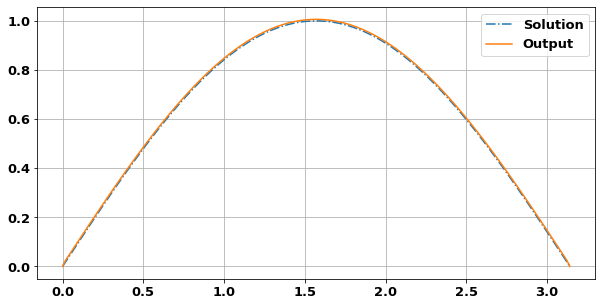

In [7]:
omega, A, rhs = homo_diffusion_problem(511, np.sin, b=np.pi)
out = multigrid(A, rhs, (jacobi, 3, 3), 2, weighted_restriction, fem_prolongation)

plt.rc("font", **font)
plt.figure(figsize=(10, 5))

plt.plot(omega, rhs, "-.", label="Solution")
plt.plot(omega, out, label="Output")

plt.legend()
plt.grid()

plt.show()

## Extensions/improvements to the Multigrid method
The Multigrid method can be improved to address specific issues in particular problems.

### Parallelization
- Standard parallelism/vectorization from Matrix-Matrix or Matrix-Vector multiplication
- Parallelization in time __[1]__

### Non-uniform grids
Non-uniform grids might be introduced by different levels of coarsening in particular areas of the grid, depending on some criteria on the current approximation of the solution __[4]__.

### Memory footprint
In the implementation above we keep all the recursive refinements until we reach the bottom. There are some variants of the multigrid method which reduce memory footprint __[4]__. The basic idea is to operate on a subdomain at a time, by tweaking the method to remove dependencies across subdomains at different levels of refinement.

## Condition number of FEM matrices
It can be shown that under some hypothesys:
$$\large \chi_{sp}(A) = O(h^{-2})$$

We can improve the condition number of the system to be solved thanks to the Multigrid method:

In [8]:
def fem1d(M, rhs_function, degree=1, a=0, b=1):
    # support points on That
    reference_vertices = np.linspace(0, 1, degree + 1)

    # number of quadrature points used to integrate on That
    n_quadrature_points = 2 * degree + 1

    # total number of basis functions on Omega
    N = M * degree + 1

    # vertices of the triangulation of Omega
    vertices = np.linspace(a, b, M + 1)

    # That
    x = np.linspace(0, 1, 51)

    # maps values from That to the k-th element
    def mapping(q, i):
        return lambda x: q[i] + x * (q[i + 1] - q[i])

    # this is the derivative of `mapping`
    def mapping_J(q, i):
        return q[i + 1] - q[i]

    # we are going to use lagrange basis as a function basis on the reference sub-domain
    def lagrange_basis(q, i):
        return lambda x: np.prod(
            [(x - q[j]) / (q[i] - q[j]) for j in range(len(q)) if i != j], axis=0
        )

    def np_lambdify(varname, func):
        lamb = sym.lambdify(varname, func, modules=["numpy"])
        if func.is_constant():
            return lambda t: np.full_like(t, lamb(t))
        else:
            return lambda t: lamb(np.array(t))

    def lagrange_basis_derivative(q, i, order=1):
        t = sym.var("t")
        return np_lambdify(t, lagrange_basis(q, i)(t).diff(t, order))

    # quadrature formula
    q, w = np.polynomial.legendre.leggauss(n_quadrature_points)
    q = (q + 1) / 2
    w = w / 2

    Q = np.array([mapping(vertices, element_idx)(q) for element_idx in range(M)])
    Xq = Q.flatten()

    # B is such that B[k][x][i] is the i-th basis evaluated at x in the k-th element
    # we have N basis functions on Omega
    B = np.zeros((M, len(x), N))

    P = np.zeros((M, degree + 1), dtype=int)
    for k in range(M):
        start = k * degree
        P[k] = np.array(range(start, start + degree + 1))

    X = np.array([mapping(vertices, k)(x) for k in range(M)])
    X2 = X.flatten()

    for k in range(M):
        # locally on each element we're going to have only degree+1 non-zero basis, the other are turned off
        # by continuity, i.e. they're set to zero in such a way that we prevent discontinuities
        B[k, :, P[k]] = np.array(
            [lagrange_basis(reference_vertices, i)(x) for i in range(degree + 1)]
        )
    B2 = B.reshape((len(X2), -1))

    Vq = np.array([lagrange_basis(reference_vertices, i)(q) for i in range(degree + 1)])

    JxW = np.array([mapping_J(vertices, element_idx) * w for element_idx in range(M)])
    JxWq = JxW.flatten()

    Bq = np.zeros((M, n_quadrature_points, N))
    Vq = np.array(
        [lagrange_basis(reference_vertices, i)(q) for i in range(degree + 1)]
    ).T

    # we can re-use the same basis since each element has the same three basis functions
    for k in range(M):
        Bq[k, :, P[k]] = Vq.T
    Bq = Bq.reshape((len(Xq), -1))

    Bprimeq = np.zeros((M, n_quadrature_points, N))
    Vprimeq = np.array(
        [lagrange_basis_derivative(reference_vertices, i)(q) for i in range(degree + 1)]
    ).T

    for k in range(M):
        Bprimeq[k, :, P[k]] = Vprimeq.T / mapping_J(vertices, k)

    Bprimeq = Bprimeq.reshape((len(Xq), -1))

    stiffness_matrix = np.einsum("qi,qj,q", Bprimeq, Bprimeq, JxWq)
    stiffness_matrix[0, :] = stiffness_matrix[-1, :] = 0
    stiffness_matrix[0, 0] = stiffness_matrix[-1, -1] = 1

    rhs = np.einsum("qi,q,q", Bq, rhs_function(Xq), JxWq)
    rhs[0] = rhs[-1] = 0

    return stiffness_matrix, rhs

In [9]:
# to mock the recursive behavior of the multigrid method
def fake_multigrid(Ah, hm_threshold, restriction, prolongation, data, func, hm=0):
    data.append(func(Ah))

    if hm == hm_threshold:
        return data
    else:
        vh = np.zeros(Ah.shape[0])
        rmatrix = restriction(vh)
        v2h = rmatrix.dot(vh)
        pmatrix = prolongation(v2h)
        A2h = rmatrix.dot((pmatrix.transpose().dot(Ah.T)).transpose())
        return fake_multigrid(
            A2h,
            hm_threshold,
            restriction,
            prolongation,
            data,
            func,
            hm=hm + 1,
        )

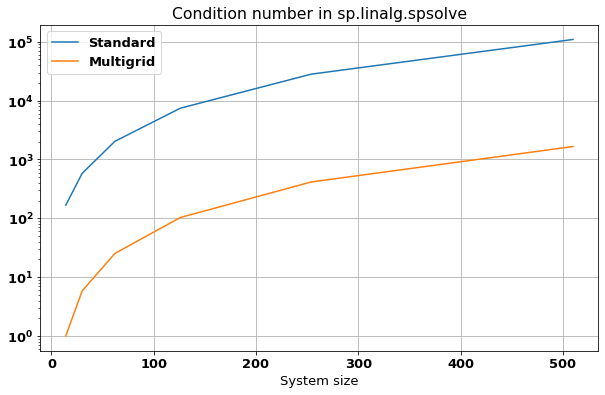

In [10]:
Ms = [14, 30, 62, 126, 254, 510]
func = lambda x: np.sin(2 * np.pi * x) * ((2 * np.pi) ** 2)

plt.figure(figsize=(10, 6))

plt.plot(Ms, [np.linalg.cond(fem1d(M, func)[0]) for M in Ms], label="Standard")
plt.plot(
    Ms,
    [
        fake_multigrid(
            fem1d(M, func)[0],
            3,
            weighted_restriction,
            fem_prolongation,
            [],
            np.linalg.cond,
        )[-1]
        for M in Ms
    ],
    label="Multigrid",
)

plt.yscale("log")
plt.title("Condition number in sp.linalg.spsolve")
plt.xlabel("System size")
plt.grid()
plt.legend()

plt.show()

## Multigrid in 2D

In [11]:
def multigrid_2d(
    Ah, fh, smoother_info, hm_threshold, n, restriction, prolongation, vh=None, hm=0, gamma=1
):
    """
    v1: pre-smoothing
    v2: post-smoothing
    smoother: (A, f, vh) -> vh'
    """
    smoother, v1, v2 = smoother_info
    nx, ny = n

    if vh is None:
        vh = np.zeros_like(fh)
    for _ in range(v1):
        vh = smoother(Ah, fh, vh)

    if hm == hm_threshold:
        vh = sp.linalg.spsolve(Ah, fh)
    else:
        nxp = (nx + 1) // 2 - 1
        nyp = (ny + 1) // 2 - 1

        rh = fh - Ah.dot(vh)
        rmatrix = restriction((rh, nx, ny))
        f2h = rmatrix.dot(rh)

        pmatrix = prolongation((f2h, nxp, nyp))
        A2h = rmatrix.dot((pmatrix.transpose().dot(Ah.T)).transpose())

        v2h = None
        for _ in range(gamma):
            v2h = multigrid_2d(
                A2h,
                f2h,
                smoother_info,
                hm_threshold,
                (nxp, nyp),
                restriction,
                prolongation,
                vh=v2h,
                hm=hm + 1,
                gamma=gamma,
            )
        vh += pmatrix.dot(v2h)

    for _ in range(v2):
        vh = smoother(Ah, fh, vh)

    return vh

## 2D Poisson problem

$$\large
\begin{cases}
-\frac{d^2u}{dx^2} = 0\\
u(\cdot) = 0 \text{ in } \partial \Omega
\end{cases}
$$


Discretization with Finite Differences:
$$\large -\frac{u_{i+1, j} - 2u_{i, j} + u_{i-1, j}}{h_x^2} -\frac{u_{i, j+1} - 2u_{i, j} + u_{i, j-1}}{h_y^2} = 0$$

In [12]:
def homo_diffusion_problem_2d(omega, N, rhs_f):
    Nx, Ny = N

    x = np.linspace(*omega[0], Nx)
    y = np.linspace(*omega[1], Ny)

    hx = x[1] - x[0]
    hy = y[1] - y[0]

    X, Y = np.meshgrid(x, y)

    inverse_squared_Nx = 1 / (hx**2)
    inverse_squared_Ny = 1 / (hy**2)

    rhs = rhs_f(X.flatten(), Y.flatten())

    data = (
        -inverse_squared_Ny * np.ones((Ny - 1) * Nx),
        -inverse_squared_Nx * np.ones(Nx * Ny - 1),
        2 * (inverse_squared_Nx + inverse_squared_Ny) * np.ones(Nx * Ny),
        -inverse_squared_Nx * np.ones(Nx * Ny - 1),
        -inverse_squared_Ny * np.ones((Ny - 1) * Nx),
    )
    A = sp.diags(data, (-Nx, -1, 0, 1, Nx), shape=(Nx * Ny, Nx * Ny), format="lil")

    # y boundary
    for i in range(Nx):
        A[i, A[i].nonzero()] = 0
        # U_{1,1}, U_{2,1}, ...
        A[i, i] = inverse_squared_Ny
        rhs[i] = 0

        j = Nx * (Ny - 1) + i
        A[j, A[j].nonzero()] = 0
        A[j, j] = inverse_squared_Ny
        rhs[j] = 0

    # x boundary (left/right)
    for i in range(1, Ny):
        j = i * Nx
        A[j, A[j].nonzero()] = 0
        # U_{1,2}, U_{1,3}, ...
        A[j, j] = inverse_squared_Nx
        rhs[j] = 0

        j = i * Nx + Nx - 1
        A[j, A[j].nonzero()] = 0
        A[j, j] = inverse_squared_Nx
        rhs[j] = 0

    return (X, Y), A.tocsr(), rhs

## Operators $I_{2h}^h/I_{h}^{2h}$

In [13]:
def fem_prolongation2d(x):
    u, nx, ny = x
    return sp.kron(
        fem_prolongation(np.empty(ny)), fem_prolongation(np.empty(nx))
    ).tocsr()


def weighted_restriction2d(x):
    u, nx, ny = x
    return sp.kron(
        weighted_restriction(np.empty(ny)),
        weighted_restriction(np.empty(nx)),
    ).tocsr()

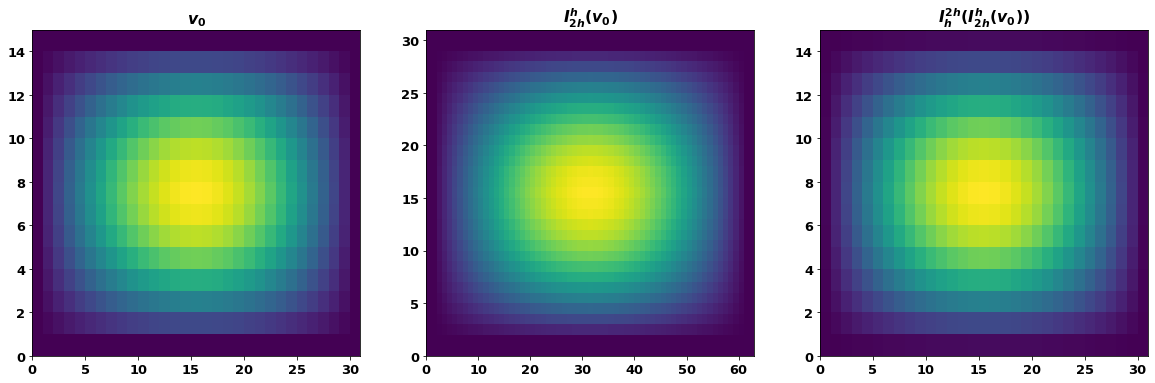

In [14]:
omega = np.zeros((2, 2))
omega[[0, 1], 1] = np.pi
nx, ny = (31, 15)


def f(x, y):
    return 2 * np.sin(x) * np.sin(y)


(X, Y), A, rhs = homo_diffusion_problem_2d(omega, (nx, ny), f)
F = f(X.flatten(), Y.flatten())

plt.rc("font", **font)
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.pcolormesh(F.reshape(ny, nx))
plt.title("$v_0$")

plt.subplot(1, 3, 2)
u = fem_prolongation2d((F, nx, ny)).dot(F)
plt.pcolormesh(u.reshape((ny + 1) * 2 - 1, (nx + 1) * 2 - 1))
plt.title("$I_{2h}^h(v_0)$")

plt.subplot(1, 3, 3)
plt.pcolormesh(
    weighted_restriction2d((u, (nx + 1) * 2 - 1, (ny + 1) * 2 - 1))
    .dot(u)
    .reshape(ny, nx)
)
plt.title("$I_h^{2h}(I_{2h}^h(v_0))$");

### Solution

In [15]:
def plot_3d(X, Y, Z, show=True):
    plt.rc("font", **font)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter("{x:.02f}")

    fig.colorbar(surf, shrink=0.6, aspect=5)
    if show:
        plt.show()

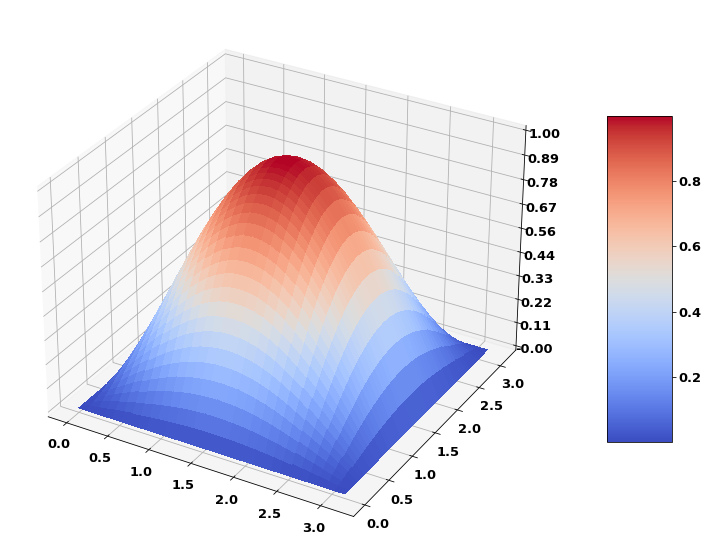

In [16]:
omega = np.zeros((2, 2))
omega[[0, 1], 1] = np.pi
nx, ny = (31, 1023)

(X, Y), A, rhs = homo_diffusion_problem_2d(omega, (nx, ny), f)
out = multigrid_2d(
    A,
    rhs,
    (conjugate_gradient, 3, 3),
    3,
    (nx, ny),
    weighted_restriction2d,
    fem_prolongation2d,
    gamma=2
)

plot_3d(X, Y, out.reshape(ny, nx))

In [17]:
omega = np.zeros((2, 2))
omega[[0, 1], 1] = np.pi
nx, ny = (127, 1023)
(X, Y), A, rhs = homo_diffusion_problem_2d(omega, (nx, ny), f)

In [18]:
%%timeit
out = multigrid_2d(
    A,
    rhs,
    (jacobi, 3, 3),
    3,
    (nx, ny),
    weighted_restriction2d,
    fem_prolongation2d,
    gamma=2
)

223 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
out = sp.linalg.spsolve(A, rhs)

956 ms ± 48.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
sizes = [15, 31, 63, 127, 255, 511, 1023, 2047, 4095]

partial_times = np.empty(5, dtype=float)
multigrid_times = np.empty(len(sizes), dtype=float)
spsolve_times = np.empty(len(sizes), dtype=float)

for idx, size in enumerate(sizes):
    nx, ny = (127, size)
    _, A, rhs = homo_diffusion_problem_2d(omega, (nx, ny), f)
    
    for i in range(partial_times.size):
        start = time.time()
        out = multigrid_2d(
            A,
            rhs,
            (jacobi, 3, 3),
            3,
            (nx, ny),
            weighted_restriction2d,
            fem_prolongation2d,
            gamma=2
        )
        partial_times[i] = time.time() - start
    multigrid_times[idx] = np.mean(partial_times)
    
    for i in range(partial_times.size):
        start = time.time()
        out = sp.linalg.spsolve(A, rhs)
        partial_times[i] = time.time() - start
    spsolve_times[idx] = np.mean(partial_times)

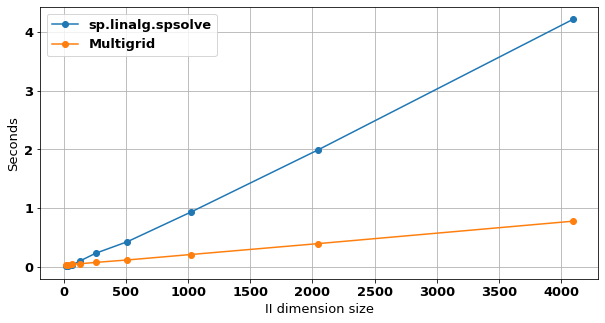

In [21]:
plt.figure(figsize=(10,5))

plt.plot(sizes, spsolve_times, '-o', label='sp.linalg.spsolve')
plt.plot(sizes, multigrid_times, '-o', label='Multigrid')

plt.legend()
plt.grid()

plt.xlabel('II dimension size')
plt.ylabel('Seconds')

plt.show()

## Application to a parabolic problem
$$\large
\begin{cases}
\frac{\partial u}{\partial t} -\frac{\partial^2u}{\partial x^2} = 0\\
u(\cdot, 0) = u(\cdot, \pi) = 0\\
u(0, \cdot) = u_0
\end{cases}
$$

## $\large v$-method for the 1D Heat Equation
Discretization with Finite Differences (parameterized on $\large v$):

$$\large
\frac{u^{n+1}_i - u^{n}_i}{k} = v \frac{u^{n+1}_{i+1} - 2u^{n+1}_i + u^{n+1}_{i-1}}{h^2} + (1-v) \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{h^2}\\
$$

In matrix form (without boundary conditions):
$$\large \mathbf{B}u^{n+1} = \mathbf{A}u^n$$

with
$$\mathbf{A} := \begin{bmatrix}
-v \mu & 1 + 2 \mu v & -v \mu & 0 & 0 & \dots & 0\\
0 & -v \mu & 1 + 2 \mu v & -v \mu & 0 & \dots & 0\\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots\\
0 & \dots & \dots & \dots & -v \mu & 1 + 2 \mu v & -v \mu
\end{bmatrix}$$

and 
$$\mathbf{B} := \begin{bmatrix}
(1 - v) \mu & 1 - 2 \mu (1 - v) & (1 - v) \mu & 0 & 0 & \dots & 0\\
0 & (1 - v) \mu & 1 - 2 \mu (1 - v) &-(1 - v) \mu & 0 & \dots & 0\\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots\\
0 & \dots & \dots & \dots & (1 - v) \mu & 1 - 2 \mu (1 - v) & (1 - v) \mu
\end{bmatrix}$$

### Stability

__Standard analysis__: $\large \mu (1 - v) \leq 1/2$
- $v = 0: \mu \leq 1/2$
- $v = 1/2: \mu \leq 1$
- $v = 1: $ unconditionally stable

__Von Neumann__: $\large \mu (1 - 2v) \leq 1/2$
$\implies $ unconditionally stable for $\large v \geq 1/2$

In [22]:
def v_method(v, omega, N):
    Nt, Nx = N
    
    t = np.linspace(*omega[0], Nt)
    x = np.linspace(*omega[1], Nx)

    k = t[1] - t[0]
    h = x[1] - x[0]

    T, X = np.meshgrid(t, x)
    mu = k / (h ** 2)

    data_A = (
        (1 - v) * mu * np.ones(Nx - 1),
        (1 - 2 * (1-v) * mu) * np.ones(Nx),
        (1 - v) * mu * np.ones(Nx - 1),
    )
    A = sp.diags(data_A, (-1, 0, 1), shape=(Nx, Nx), format="lil")
    
    A[0, A[0].nonzero()] = 0
    A[-1, A[-1].nonzero()] = 0
    A[0, 0] = A[-1, -1] = 1
    
    data_B = (
        -v * mu * np.ones(Nx - 1),
        (1 + 2 * v * mu) * np.ones(Nx),
        -v * mu * np.ones(Nx - 1),
    )
    B = sp.diags(data_B, (-1, 0, 1), shape=(Nx, Nx), format="lil")
    
    B[0, B[0].nonzero()] = 0
    B[-1, B[-1].nonzero()] = 0
    B[0, 0] = B[-1, -1] = 1
    
    rhs[[0, -1]] = 0
    
    return (T,X), A.tocsr(), B.tocsr()

### Linearly increasing/decreasing initial condition with peak in the middle

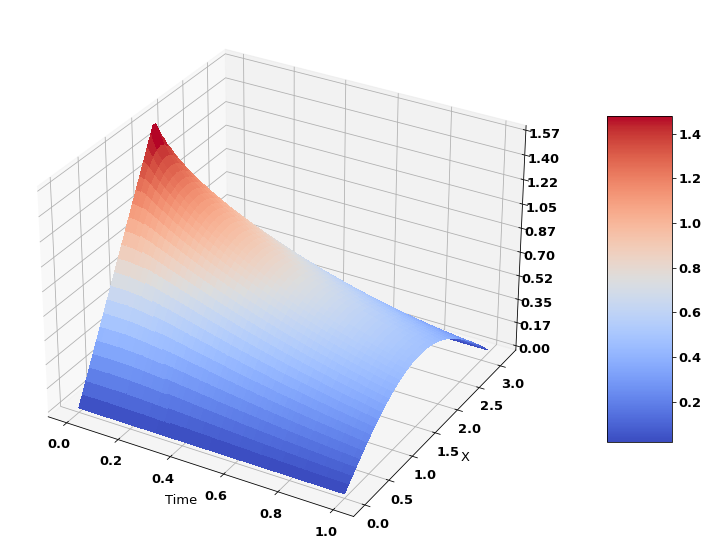

In [23]:
omega = np.zeros((2,2))
omega[0] = [0,1]
omega[1] = [0, np.pi]

nt = 1000
nx = 127

(T, X), A, B = v_method(1, omega, (nt, nx))
u = np.empty((nt, nx))

u0 = np.linspace(0, np.pi/2, nx//2)
u0 = np.concatenate((u0, [np.pi / 2], u0[::-1]))

u[0] = u0
for i in range(1,nt):
    u[i] = multigrid(
        B,
        A.dot(u[i-1]),
        (jacobi, 3, 3),
        3,
        weighted_restriction,
        fem_prolongation,
        gamma=2,
        solver=sp.linalg.spsolve
    )
    
plot_3d(T, X, u.T, show=False)
plt.xlabel('Time')
plt.ylabel('X')
plt.show()

### Fixed temperature insulated bar ($\large u_0 =$ constant)

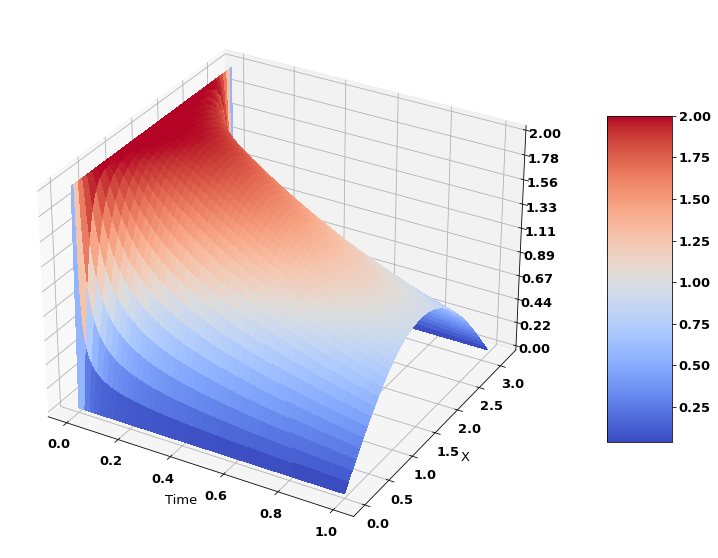

In [24]:
(T, X), A, B = v_method(1, omega, (nt, nx))
u = np.empty((nt, nx))

u0 = 2 * np.ones(nx)
u0[0] = u0[-1] = 0

u[0] = u0
for i in range(1,nt):
    u[i] = multigrid(
        B,
        A.dot(u[i-1]),
        (jacobi, 3, 3),
        3,
        weighted_restriction,
        fem_prolongation,
        gamma=2,
        solver=sp.linalg.spsolve
    )
    
plot_3d(T, X, u.T, show=False)
plt.xlabel('Time')
plt.ylabel('X')
plt.show()

### Unstable discretization: $\large v < 1/2$ with $\large \mu = 2$

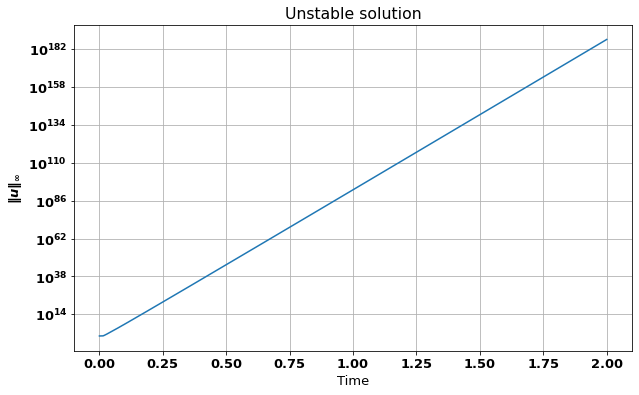

In [25]:
omega = np.zeros((2,2))
omega[0] = [0,2]
omega[1] = [0, np.pi]

nt = 1630
nx = 127

(T, X), A, B = v_method(0.3, omega, (nt, nx))
u = np.empty((nt, nx))

u0 = 2 * np.ones(nx)
u0[0] = u0[-1] = 0

u[0] = u0
for i in range(1,nt):
    u[i] = multigrid(
        B,
        A.dot(u[i-1]),
        (jacobi, 3, 3),
        3,
        weighted_restriction,
        fem_prolongation,
        gamma=2,
        solver=sp.linalg.spsolve
    )
    
plt.figure(figsize=(10,6))
plt.plot(np.linspace(*omega[0], nt), np.max(u, axis=1))

plt.xlabel('Time')
plt.ylabel('$\Vert u\Vert_\infty$')
plt.title('Unstable solution')

plt.grid()
plt.yscale('log')

plt.show()

## References
1. Horton, Graham. "The time‐parallel multigrid method." Communications in applied numerical methods 8.9 (1992): 585-595.
2. Volker, John. "Notes on multigrid methods"
3. William L. Briggs. "A Multigrid Tutorial"
4. Achi Brandt. "Multi-level adaptive solutions to Boundary-Value problems"